In [1]:
import epics
import numpy as _np
from scipy.optimize import curve_fit as _curve_fit

from mathphys.imgproc import Image2D_Fit as _Image2D_Fit
from mathphys.imgproc import FitGaussianScipy as _FitGaussianScipy
from siriuspy.devices import Device as _Device, DVF as _DVF

In [2]:
class DVFImgProc(_DVF):
    """."""
    
    _TIMEOUT_DEFAULT = 5  # [s]
    
    _properties = _DVF._properties + (
        'ImgProperties-Cte', 
        'ImgTimestampBoot-Cte', 
        'ImgTimestampUpdate-Mon', 
        'ImgVersion-Cte', 

        'ImgSizeX-Cte', 'ImgSizeY-Cte',
        'ImgIntensityMax-Mon', 'ImgIntensityMin-Mon',
        'ImgIntensitySum-Mon', 'ImgIsSaturated-Mon',

        'ImgROIX-RB' ,'ImgROIX-SP',
        'ImgROIXCenter-Mon', 'ImgROIXFWHM-Mon',
        'ImgROIY-RB', 'ImgROIY-SP',
        'ImgROIYCenter-Mon', 'ImgROIYFWHM-Mon',

        'ImgLog-Mon',
        'ImgROIUpdateWithFWHM-Sel', 'ImgROIUpdateWithFWHM-Sts',
        'ImgROIYUpdateWithFWHMFactor-RB', 'ImgROIYUpdateWithFWHMFactor-SP',
        'ImgROIXUpdateWithFWHMFactor-RB', 'ImgROIXUpdateWithFWHMFactor-SP',

        'ImgROIXFitMean-Mon', 'ImgROIXFitSigma-Mon',
        'ImgROIXFitAmplitude-Mon', 'ImgROIXFitError-Mon',
        'ImgROIYFitMean-Mon', 'ImgROIYFitSigma-Mon',
        'ImgROIYFitAmplitude-Mon', 'ImgROIYFitError-Mon',
        'ImgFitAngle-Mon',
        )        
        
    _DVF_IMAGE_PROPTY = 'image1:ArrayData'
    
    def __init__(self, devname, *args, **kwargs):
        """."""
        super().__init__(devname=devname, *args, **kwargs)
        self.wait_for_connection(timeout=DVFImgProc._TIMEOUT_DEFAULT)
        self.cmd_update()
        self._add_callback_image()
        
    @property
    def roiy(self):
        """."""
        return self['ImgROIY-RB']
    
    @roiy.setter
    def roiy(self, value):
        """."""
        self['ImgROIY-SP'] = value
    
    @property
    def roix(self):
        """."""
        return self['ImgROIX-RB']
    
    @roix.setter
    def roix(self, value):
        """."""
        self['ImgROIX-SP'] = value

    @property
    def roiy_center(self):
        """."""
        return self['ImgROIYCenter-Mon']
    
    @property
    def roix_center(self):
        """."""
        return self['ImgROIXCenter-Mon']
    
    @property
    def roiy_fwhm(self):
        """."""
        return self['ImgROIYFWHM-Mon']
    
    @property
    def roix_fwhm(self):
        """."""
        return self['ImgROIXFWHM-Mon']
    
    @property
    def roiy_fit_mean(self):
        """."""
        return self['ImgROIYFitMean-Mon']
    
    @property
    def roix_fit_mean(self):
        """."""
        return self['ImgROIXFitMean-Mon']
    
    @property
    def roiy_fit_sigma(self):
        """."""
        return self['ImgROIYFitSigma-Mon']
    
    @property
    def roix_fit_sigma(self):
        """."""
        return self['ImgROIXFitSigma-Mon']
    
    @property
    def roiy_fwhm_factor(self):
        """."""
        return self['ImgROIYUpdateWithFWHMFactor-RB']
    
    @roiy_fwhm_factor.setter
    def roiy_fwhm_factor(self, value):
        """."""
        self['ImgROIYUpdateWithFWHMFactor-SP'] = value
        
    @property
    def roix_fwhm_factor(self):
        """."""
        return self['ImgROIXUpdateWithFWHMFactor-RB']
    
    @roix_fwhm_factor.setter
    def roix_fwhm_factor(self, value):
        """."""
        self['ImgROIXUpdateWithFWHMFactor-SP'] = value
    
    @property
    def roi_with_fwhm(self):
        """."""
        return self['ImgROIUpdateWithFWHM-Sts']
    
    @roi_with_fwhm.setter
    def roi_with_fwhm(self, value):
        """."""
        self['ImgROIUpdateWithFWHM-Sel'] = value == True
        
    @property
    def image2dfit(self):
        """."""
        return self._image2dfit
    
    def cmd_update(self, *args, **kwargs):
        """."""
        curve_fit = _FitGaussianScipy(curve_fit_func=_curve_fit)
        self._image2dfit = _Image2D_Fit(data=self.image, curve_fit=curve_fit, roix=self.roix, roiy=self.roiy)
        
    def _add_callback_image(self):
        """."""
        imgpv = self.pv_object(DVFImgProc._DVF_IMAGE_PROPTY)
        imgpv.add_callback(self.cmd_update)

def update_image(dvfimgproc):
    dvfimgproc.cmd_acquire_on()
    dvfimgproc.cmd_update()
    img = dvfimgproc.image2dfit
    return img

In [3]:
dvfimgproc = DVFImgProc(devname=DVFImgProc.DEVICES.CAX_DVF2)

In [4]:
dvfimgproc.connected

True

# Test ROI and fitting

In [5]:
dvfimgproc.image2dfit

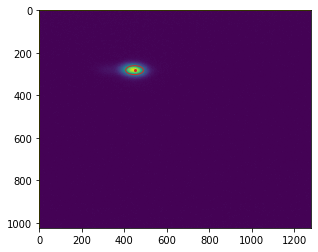

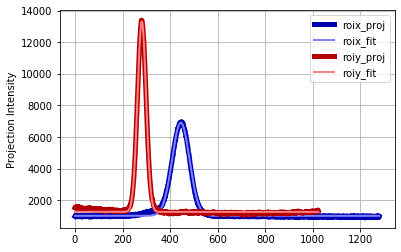

In [6]:
img = update_image(dvfimgproc)
img.imshow()
img.plot_projections()

In [11]:
factor = 5

cx, cy = dvfimgproc.roix_fit_mean, dvfimgproc.roiy_fit_mean
sx, sy = dvfimgproc.roix_fwhm, dvfimgproc.roiy_fwhm

print('mean: ', cx, cy)
print('fwhm: ', sx, sy)

# calc new roi
roix = int(cx - factor * sx/2), int(cx + factor * sx/2)
roiy = int(cy - factor * sy/2), int(cy + factor * sy/2)

print('roix: ', roix)
print('roiy: ', roiy)

mean:  448.6336575823473 281.719882188135
fwhm:  85 41
roix:  (236, 661)
roiy:  (179, 384)


In [21]:
# set roi

dvfimgproc.roix = roix
dvfimgproc.roiy = roiy

# ROIUpdateFWHM

In [12]:
print('roix_fwhm_factor: ', dvfimgproc.roix_fwhm_factor)
print('roiy_fwhm_factor: ', dvfimgproc.roiy_fwhm_factor)

roix_fwhm_factor:  2.0
roiy_fwhm_factor:  2.0


In [13]:
dvfimgproc.fwhmx_factor = 1.5
dvfimgproc.fwhmy_factor = 1.5

In [33]:
dvfimgproc.roi_with_fwhm

0

In [32]:
dvfimgproc.roi_with_fwhm = 0

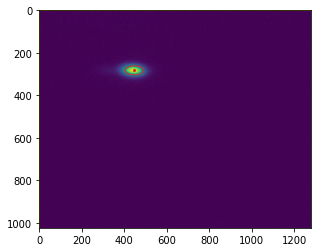

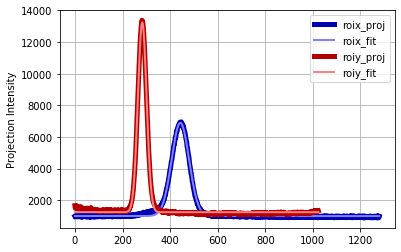

In [13]:
img = update_image(dvfimgproc)
img.imshow()
img.plot_projections()